In [1]:
#라이브러리 & 데이터 로드
# 필수 라이브러리
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import shap

# 데이터 로드
df = pd.read_csv('uci-secom.csv')

# 데이터 확인
print(df.shape)
print(df.head())
print(df['Pass/Fail'].value_counts())

(1567, 592)
                  Time        0        1          2          3       4      5  \
0  2008-07-19 11:55:00  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   
1  2008-07-19 12:32:00  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0   
2  2008-07-19 13:17:00  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   
3  2008-07-19 14:43:00  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0   
4  2008-07-19 15:22:00  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0   

          6       7       8  ...       581     582     583     584      585  \
0   97.6133  0.1242  1.5005  ...       NaN  0.5005  0.0118  0.0035   2.3630   
1  102.3433  0.1247  1.4966  ...  208.2045  0.5019  0.0223  0.0055   4.4447   
2   95.4878  0.1241  1.4436  ...   82.8602  0.4958  0.0157  0.0039   3.1745   
3  104.2367  0.1217  1.4882  ...   73.8432  0.4990  0.0103  0.0025   2.0544   
4  100.3967  0.1235  1.5031  ...       NaN  0.4800  0.4766  0.1045  99.3032   

      586     587     588 

In [2]:
#결측치 기반 컬럼 제거
missing_ratio = df.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > 0.7].index
df_reduced = df.drop(columns=cols_to_drop)
print("제거된 컬럼 수:", len(cols_to_drop))
print("남은 컬럼 수:", df_reduced.shape[1])

제거된 컬럼 수: 8
남은 컬럼 수: 584


In [4]:
#저분산 변수 제거
X = df_reduced.drop(columns=['Pass/Fail'])
y = df_reduced['Pass/Fail']

# 'Time' 컬럼이 숫자형이 아니므로 제거
X = X.drop(columns=['Time'])

X_temp = X.fillna(X.median())
selector = VarianceThreshold(threshold=0.01)
X_var = selector.fit_transform(X_temp)
selected_features = X_temp.columns[selector.get_support()]
X_selected = X_temp[selected_features]

print("저분산 제거 후 변수 수:", len(selected_features))

저분산 제거 후 변수 수: 311


In [5]:
#상관관계 높은 변수 제거
corr_matrix = X_selected.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.95)]
X_final = X_selected.drop(columns=to_drop_corr)
print("상관관계 제거 변수 수:", len(to_drop_corr))
print("최종 변수 수:", X_final.shape[1])

상관관계 제거 변수 수: 109
최종 변수 수: 202


In [6]:
#Train/Test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, stratify=y, random_state=42
)

print("Train 불량 비율:\n", y_train.value_counts(normalize=True))
print("Test 불량 비율:\n", y_test.value_counts(normalize=True))

Train 불량 비율:
 Pass/Fail
-1    0.933759
 1    0.066241
Name: proportion, dtype: float64
Test 불량 비율:
 Pass/Fail
-1    0.933121
 1    0.066879
Name: proportion, dtype: float64


In [7]:
#Logistic Regression — 해석력 모델
# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic 모델
model_lr = LogisticRegression(max_iter=10000, class_weight='balanced')
model_lr.fit(X_train_scaled, y_train)

y_pred = model_lr.predict(X_test_scaled)
y_prob = model_lr.predict_proba(X_test_scaled)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

          -1       0.94      0.89      0.91       293
           1       0.11      0.19      0.14        21

    accuracy                           0.84       314
   macro avg       0.52      0.54      0.53       314
weighted avg       0.88      0.84      0.86       314

ROC-AUC: 0.6869819600195026


In [8]:
#XGBoost — 비선형 모델 + 불량 탐지
# 라벨 변환 (0=정상, 1=불량)
y_train_xgb = y_train.replace(-1,0)
y_test_xgb = y_test.replace(-1,0)

# scale_pos_weight
scale_weight = (y_train_xgb==0).sum() / (y_train_xgb==1).sum()

# XGBoost 학습
model_xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    scale_pos_weight=scale_weight,
    random_state=42,
    eval_metric='logloss'
)
model_xgb.fit(X_train_scaled, y_train_xgb)

y_pred_xgb = model_xgb.predict(X_test_scaled)
y_prob_xgb = model_xgb.predict_proba(X_test_scaled)[:,1]

print(classification_report(y_test_xgb, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test_xgb, y_prob_xgb))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       293
           1       0.00      0.00      0.00        21

    accuracy                           0.93       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.87      0.93      0.90       314

ROC-AUC: 0.7971721111652852


In [9]:
#Threshold 최적화
precision, recall, thresholds = precision_recall_curve(y_test_xgb, y_prob_xgb)
f1_scores = 2*(precision*recall)/(precision+recall+1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print("Best Threshold:", best_threshold)

# 최적 threshold 적용
y_pred_best = (y_prob_xgb >= best_threshold).astype(int)
print(classification_report(y_test_xgb, y_pred_best))

Best Threshold: 0.051882703
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       293
           1       0.32      0.48      0.38        21

    accuracy                           0.90       314
   macro avg       0.64      0.70      0.66       314
weighted avg       0.92      0.90      0.91       314



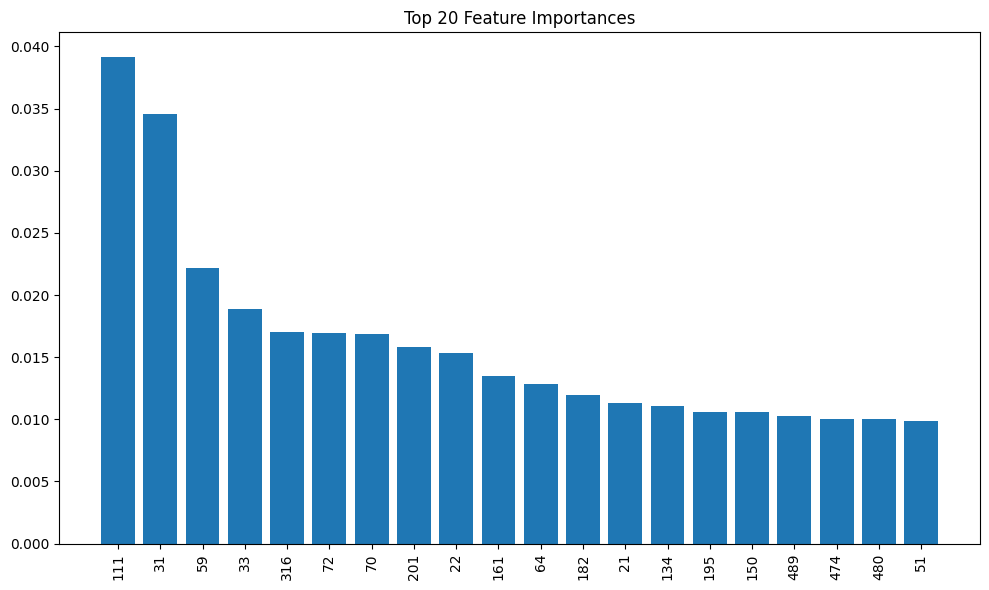

In [10]:
#Feature Importance — 공정 영향 센서 확인
importances = model_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_final.columns

plt.figure(figsize=(10,6))
plt.title("Top 20 Feature Importances")
plt.bar(range(20), importances[indices][:20], align='center')
plt.xticks(range(20), features[indices][:20], rotation=90)
plt.tight_layout()
plt.show()